In [35]:
import os
import glob
import filament
import datetime
import netCDF4
import cmocean
import logging
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from importlib import reload
reload(filament)

<module 'filament' from '/home/ctroupin/Projects/FNRS-UpwellingFilaments/Filament-Submesoscale/python/filament.py'>

In [36]:
logger = logging.getLogger("eddyPlot")
logger.setLevel(logging.INFO)
logging.info("Starting")
plotvis = 1

In [52]:
datadir = "/data/SST/Balearic/1/"
figdir = os.path.join(datadir, "figures")
visibledir = "/data/Visible/"
datafilelist = sorted(glob.glob(os.path.join(datadir, "*SST*.nc")))
datafilelist2 = sorted(glob.glob(os.path.join(datadir, "*SNPP*OC*.nc")))
nfiles = len(datafilelist)
logger.info("Processing {} files".format(nfiles))

INFO:eddyPlot:Processing 1 files


In [48]:
if not(os.path.exists(figdir)):
    os.makedirs(figdir)

In [50]:
coordinates = (2., 10., 37., 42.)
m = Basemap(projection='merc', llcrnrlon=coordinates[0], llcrnrlat=coordinates[2],
            urcrnrlon=coordinates[1], urcrnrlat=coordinates[3],
            epsg=4326, resolution='h')

In [54]:
for datafile in datafilelist:
    print(datafile)
    with netCDF4.Dataset(datafile) as nc:
        proclevel = nc.processing_level
        
    sst = filament.SST()
    
    # Select the reader according to processing level
    if proclevel == "L3 Mapped":
        logger.info("Level-3 data")
        sst.read_from_oceancolorL3(datafile, coordinates)
    elif proclevel == "L2":
        logger.info("Level-2 data")
        sst.read_from_oceancolorL2(datafile)
        sst.field = np.ma.masked_where(sst.qflag > 1, sst.field)
    
    # Plot without visible
    figname = os.path.join(figdir, sst.get_figname())
    sst.make_plot(m, figname=figname, vmin=20, vmax=25., shrink=0.7)
    
    
    # With visible image background
    """
    visiblefile = os.path.join(visibledir, "VIIRS_{}.tiff".format(sst.date.strftime("%Y%m%d")))
    if os.path.exists(visiblefile):
        visibleim = filament.Visible()
        visibleim.read_from(visiblefile)
        visibleim.extract_area(coordinates)
    figname = os.path.join(figdir, "_".join((sst.get_figname(), "visible")))
    sst.make_plot2(m, figname=figname, visibleim=visibleim, vmin=17., vmax=24.)
    """

INFO:eddyPlot:Level-2 data


/data/SST/Balearic/1/T2019284214500.L2_LAC_SST.nc


## Chlorophyll

In [22]:
def read_chloro_from_oceancolorL2(filename):
    """
    Load the chlorophyll concentration from netCDF L2 file obtained from
    https://oceancolor.gsfc.nasa.gov
    :param filename: name of the netCDF file
    :return: lon, lat, field, qflag, year, dayofyear
    """

    if os.path.exists(filename):
        with netCDF4.Dataset(filename) as nc:
            # Read platform
            sat = nc.platform
            # Read time information
            # Assume all the measurements made the same day (and same year)
            year = int(nc.groups['scan_line_attributes'].variables['year'][0])
            dayofyear = int(nc.groups['scan_line_attributes'].variables['day'][0])
            # Convert to date
            date = datetime.datetime(year, 1, 1) + datetime.timedelta(dayofyear - 1)
            # Read coordinates
            lon = nc.groups['navigation_data'].variables['longitude'][:]
            lat = nc.groups['navigation_data'].variables['latitude'][:]
            # Read geophysical variables
            chloro = nc.groups['geophysical_data'].variables['chlor_a'][:]
            
    return lon, lat, chloro

/data/SST/Balearic/V2019332124200.L2_SNPP_OC.nc


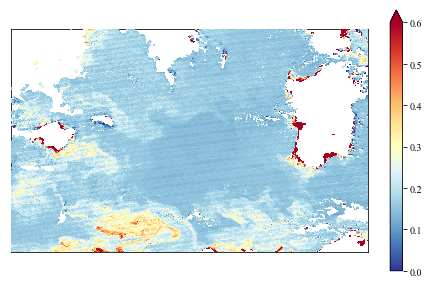

In [30]:
for datafile in datafilelist2:
    print(datafile)
    with netCDF4.Dataset(datafile) as nc:
        proclevel = nc.processing_level
        
    lon, lat, chloro = read_chloro_from_oceancolorL2(datafile)

    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111)
    pcm = m.pcolormesh(lon, lat, chloro, latlon=True, vmin=0, vmax=0.6,
                       cmap=plt.cm.RdYlBu_r, zorder=6)
    plt.colorbar(pcm, extend="max", shrink=0.6)
    
    plt.show()
    # With visible image background
    """
    visiblefile = os.path.join(visibledir, "VIIRS_{}.tiff".format(sst.date.strftime("%Y%m%d")))
    if os.path.exists(visiblefile):
        visibleim = filament.Visible()
        visibleim.read_from(visiblefile)
        visibleim.extract_area(coordinates)
    figname = os.path.join(figdir, "_".join((sst.get_figname(), "visible")))
    sst.make_plot2(m, figname=figname, visibleim=visibleim, vmin=17., vmax=24.)
    """